### CODE for Overfitting

100%|██████████| 170M/170M [00:24<00:00, 7.02MB/s] 


Epoch 1/100 => Train Loss: 5.9837 | Test Loss: 2.2602
Epoch 2/100 => Train Loss: 2.2068 | Test Loss: 2.2411
Epoch 3/100 => Train Loss: 2.0464 | Test Loss: 2.3644
Epoch 4/100 => Train Loss: 1.8193 | Test Loss: 2.4331
Epoch 5/100 => Train Loss: 1.7963 | Test Loss: 2.7829
Epoch 6/100 => Train Loss: 1.6277 | Test Loss: 2.7295
Epoch 7/100 => Train Loss: 1.9236 | Test Loss: 3.0648
Epoch 8/100 => Train Loss: 1.7803 | Test Loss: 2.7566
Epoch 9/100 => Train Loss: 1.7519 | Test Loss: 3.3534
Epoch 10/100 => Train Loss: 1.9422 | Test Loss: 2.7050
Epoch 11/100 => Train Loss: 1.9382 | Test Loss: 2.5621
Epoch 12/100 => Train Loss: 1.9007 | Test Loss: 2.6258
Epoch 13/100 => Train Loss: 1.7847 | Test Loss: 3.5125
Epoch 14/100 => Train Loss: 1.9378 | Test Loss: 3.3058
Epoch 15/100 => Train Loss: 1.8024 | Test Loss: 2.8862
Epoch 16/100 => Train Loss: 1.6866 | Test Loss: 3.2408
Epoch 17/100 => Train Loss: 1.8778 | Test Loss: 2.9161
Epoch 18/100 => Train Loss: 1.8237 | Test Loss: 2.7589
Epoch 19/100 => Tra

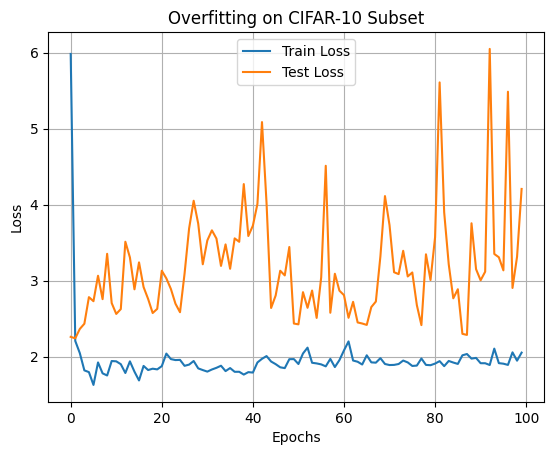

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Mean and std for normalization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

# Custom transformation
def custom_transformation(image):
    image = np.array(image) / 255.0
    image = (image - mean) / std
    image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) 
    return image

# Load CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, transform=None, download=True)
testset = CIFAR10(root='./data', train=False, transform=None, download=True)

# Apply transformation
def apply_transform(dataset):
    transformed_data = []
    for image, label in dataset:
        image_tensor = custom_transformation(image)
        transformed_data.append((image_tensor, label)) # Agiko Error transformed_data.append (image_tensor, label) auta bracket xuteko raixa.
    return transformed_data

trainset = apply_transform(trainset)[:500]
testset = apply_transform(testset)[:200]

# Dataloaders
train_loader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=32, shuffle=False)

# Model
class OverFitNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  
        x = self.fc3(x)
        return x

# Model, loss, optimizer
model = OverFitNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for image, label in train_loader:
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)  
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Overfitting on CIFAR-10 Subset")
plt.legend()
plt.grid(True)
plt.show()


### Assignment: Add Dropout, L2 Regularization, and Early Stopping to the Model



# Vanishing Gradient Problem

---

## What is the Vanishing Gradient Problem?

The **Vanishing Gradient Problem** occurs during the training of deep neural networks, especially those with many layers or recurrent connections. It refers to the issue where the gradients of the loss function with respect to parameters in early layers become **exceedingly small**, almost approaching zero.

Because of this, **weights in the earlier layers update very slowly or stop updating altogether**, preventing the network from effectively learning.

---

## Why Does It Happen?

During backpropagation, gradients are calculated using the **chain rule** of derivatives:

$$
\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial a_n} \cdot \frac{\partial a_n}{\partial a_{n-1}} \cdot \frac{\partial a_{n-1}}{\partial a_{n-2}} \cdots \frac{\partial a_{i+1}}{\partial w_i}
$$

Where:  
- $L$ is the loss  
- $w_i$ is a weight parameter in layer $i$  
- $a_i$ is the activation of layer $i$

Each term is a derivative of an activation function or linear transformation. When these derivatives are **less than 1**, multiplying many such terms causes the gradient to exponentially shrink as we move backward through layers.

---

## Mathematical Intuition

If each layer’s gradient term is approximately some constant $c$ with $0 < c < 1$, then for $n$ layers, the gradient shrinks roughly as:

$$
\text{Gradient} \approx c^n
$$

As $n$ grows large, $c^n \to 0$, causing gradients to vanish.

---

## Which Activation Functions Contribute to the Problem?

- **Sigmoid function:**

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Its derivative:

$$
\sigma'(x) = \sigma(x)(1 - \sigma(x))
$$

Since $\sigma(x)$ saturates near 0 or 1, its derivative approaches zero at extremes, causing very small gradients.

- **Tanh function:**

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

Derivative:

$$
\tanh'(x) = 1 - \tanh^2(x)
$$

Saturates near $\pm 1$ causing gradients near zero.

---

## Consequences of Vanishing Gradients

- Early layers **learn very slowly or stop learning**.
- Network becomes unable to capture **long-range dependencies**.
- Training stalls or is very slow.
- Commonly seen in **deep feedforward networks** and **RNNs**.

---

## Example in Recurrent Neural Networks (RNNs)

RNNs multiply the same weight matrix repeatedly through time steps. This repeated multiplication causes gradients to vanish (or sometimes explode). This is why vanilla RNNs struggle to learn long sequences.

---

## How to Mitigate Vanishing Gradient?

### 1. Use Activation Functions that Avoid Saturation

- Use **ReLU (Rectified Linear Unit):**

$$
\text{ReLU}(x) = \max(0, x)
$$

Derivative is either 0 or 1, avoiding gradient shrinking.


### 2. Use Normalization Layers

- **Batch Normalization** normalizes activations, reducing internal covariate shift and helping gradient flow.

### 3. Use Residual Connections (Skip Connections)

- Networks like **ResNet** add skip connections to allow gradients to flow directly to earlier layers.

### 4. Use Specialized Architectures for Sequences

- **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Units)** are designed to combat vanishing gradients in RNNs.

---

## Summary

| Aspect                    | Description                               |
|---------------------------|-------------------------------------------|
| Problem                   | Gradients become too small in deep networks |
| Cause                     | Chain rule multiplication of derivatives < 1 |
| Affected Activation Functions | Sigmoid, Tanh                          |
| Impact                    | Slow/no learning in early layers          |
| Solutions                 | ReLU, Batch Norm, Residual Connections, LSTM/GRU |

---

## Visual Intuition

Imagine multiplying many small numbers between 0 and 1 repeatedly: the result quickly approaches zero, similarly gradients vanish when propagated backward through many layers.

---



# Batch Normalization

---

## What is Batch Normalization?

Batch Normalization (BatchNorm) is a technique to **normalize the inputs of each layer** within a neural network, improving training speed, stability, and performance. 

---

## Why Use Batch Normalization?

- **Reduces Internal Covariate Shift:**  
  The distribution of inputs to layers changes during training as parameters of previous layers change. BatchNorm reduces this shift by normalizing layer inputs.
  
- **Speeds up Training:**  
  Allows higher learning rates and reduces the need for careful initialization.
  
- **Acts as a Regularizer:**  
  Sometimes reduces the need for dropout.

---

## How Does Batch Normalization Work?

Given a mini-batch of inputs to a layer:  
$$
\mathcal{B} = \{x_1, x_2, \ldots, x_m\}
$$
where $m$ is the batch size and $x_i$ is the input for example $i$.

### Step 1: Compute Batch Mean

$$
\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^m x_i
$$

### Step 2: Compute Batch Variance

$$
\sigma_{\mathcal{B}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\mathcal{B}})^2
$$

### Step 3: Normalize

$$
\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}
$$

Where $\epsilon$ is a small constant added for numerical stability.

### Step 4: Scale and Shift

To allow the network to learn optimal scale and shift, BatchNorm introduces two learnable parameters:  
- $\gamma$ (scale)  
- $\beta$ (shift)

The output of batch normalization is:

$$
y_i = \gamma \hat{x}_i + \beta
$$

---

## Where is BatchNorm Applied?

- Typically applied **after the linear transformation and before the activation function** in each layer.
- Works for fully connected and convolutional layers (with some variations).

---

## Benefits of Batch Normalization

- Allows use of **higher learning rates** without the risk of divergence.
- Makes the training process **less sensitive** to initialization.
- Acts as a **regularizer**, often reducing the need for dropout.
- Helps **mitigate the vanishing/exploding gradient problems** by keeping inputs to layers normalized.

---

## Important Notes

- During **training**, batch statistics (mean and variance) are computed on the current mini-batch.
- During **inference**, moving averages of the mean and variance (accumulated during training) are used.
- The learnable parameters $\gamma$ and $\beta$ allow the network to represent the identity transform if necessary.

---

## Mathematical Summary

For each feature in the batch:

1. Compute mean:  
$$
\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^m x_i
$$

2. Compute variance:  
$$
\sigma_{\mathcal{B}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\mathcal{B}})^2
$$

3. Normalize inputs:  
$$
\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}
$$

4. Scale and shift:  
$$
y_i = \gamma \hat{x}_i + \beta
$$

---

## Summary Table

| Step                 | Description                      |
|----------------------|---------------------------------|
| Compute batch mean   | Mean of current mini-batch       |
| Compute batch variance | Variance of current mini-batch  |
| Normalize inputs     | Zero mean, unit variance         |
| Scale & shift        | Learnable parameters $\gamma$, $\beta$ |

---

## Impact on Training

- **Faster convergence**
- **Improved accuracy**
- **Reduced sensitivity to initialization**
- **Helps with gradient flow**

---

## Final Remarks

Batch Normalization is now a **standard component** in most modern deep neural network architectures. It can be combined with other techniques like dropout and residual connections for robust training.

---

